In [143]:
#importing libraries
import pandas as pd
import numpy as np
import os
from varname import nameof
import string
import nltk
from nltk.corpus import stopwords

#deep learning library
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import CSVLogger
from tensorflow.python.keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten

seed = 1337

### Import and explore data

In [2]:
yelp_labelled = pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
yelp_labelled.columns = ['text', 'label']
yelp_labelled.head(5)

,text,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


<AxesSubplot:xlabel='label', ylabel='Count'>

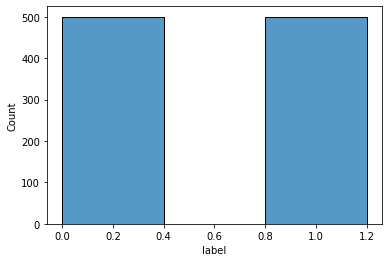

In [3]:
sns.histplot(data=yelp_labelled, x="label",bins=2,binwidth=0.4)


- 0 and 1 labels are equally distributed, so we do not need to resample the data
- 0 is a bad review, 1 is a good review
- small set of data, so we can use all of it

,text,label
297,Main thing I didn't enjoy is that the crowd is...,0
877,Go To Place for Gyros.,1
501,Any grandmother can make a roasted chicken bet...,0
81,"Overall, a great experience.",1
399,And the red curry had so much bamboo shoots an...,0


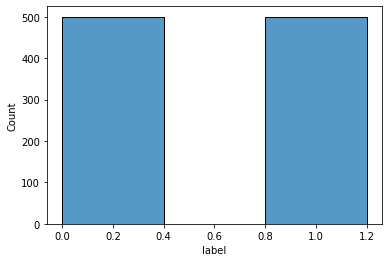

In [147]:
y = yelp_labelled['label']
train_df, test_df = train_test_split(yelp_labelled, test_size=0.2)
sns.histplot(data=yelp_labelled, x="label",bins=2,binwidth=0.4)
train_df.head()


### Vectorize the word data: building my own word dictionary
- a neural network model cannot interpret words, they need to be encoded into numbers
- external libraries exist that do this, like Word2Vec
- After playing around with the libraries I decided to make my own encoding to fully understand how the basics work
- getting rid of stop words made the model perform worse. Understandable since sequentially many of the stop words actually add information to the phrases! 

In [102]:
# separate into positive and negative posts
positive_posts = pd.Series.to_numpy(yelp_labelled[yelp_labelled.label == 1]['text'])
negative_posts = pd.Series.to_numpy(yelp_labelled[yelp_labelled.label == 0]['text'])

# keep an object with both sets for later use
posts = np.append(negative_posts, positive_posts, axis=0)

longest_post = max(len(post) for post in posts)
longest_post


149

In [148]:
def unique_words(lines):
    '''
    returns dictionary of unique words in input
    assigns an integer key to each word
    does not include punctuation or stop words 
    stop words can be removed or included depending on if it benefits the model
    '''
    unique_words = set()
    stop_words = set(stopwords.words('english'))

    for line in lines:
        for word in line:
#             if word not in stop_words:
#                 unique_words.add(word)
            unique_words.add(word)
    word_vals = set(i for i in range(len(unique_words)))
    word_keys = dict(zip(unique_words, word_vals))
    return word_keys

def word_to_vec(posts):
    '''
    encodes word input into integer arrays 
    stop words can be removed or included depending on the model
    '''
    stop_words = set(stopwords.words('english'))
    posts = [line.lower().translate(str.maketrans('', '', string.punctuation)).split(' ') for line in posts]
    word_dict = unique_words(posts)
    word_key_map = [[word_dict[word] for word in post] for post in posts]
#     word_key_map = [[word_dict[word] for word in post if word not in stop_words] for post in posts]
    return word_key_map

In [149]:
neg_encoded = word_to_vec(negative_posts)
pos_encoded = word_to_vec(positive_posts)
word_vecs = np.concatenate((neg_encoded, pos_encoded))
print(f'"{negative_posts[0]}" becomes {word_vecs[0]}')


"Overpriced for what you are getting." becomes [267, 1283, 507, 941, 316, 679]


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [150]:
# Padding the data samples to a maximum review length in words
longest_post = max([len(post) for post in word_to_vec(posts)])
padded_word_vecs = sequence.pad_sequences(word_vecs, maxlen=longest_post)


In [151]:
# re-create labels, concatenate with data, and set up test/train split
labels = np.concatenate((np.zeros(len(neg_encoded)), np.ones(len(pos_encoded))))
X_train, X_test, y_train, y_test = train_test_split(padded_word_vecs,labels,test_size=0.33)

print('X_train shape:', X_train.shape, y_train.shape)
print('X_test shape:', X_test.shape, y_test.shape)


X_train shape: (670, 32) (670,)
X_test shape: (330, 32) (330,)


In [175]:
#### Setting up model fitting functions to avoid code redundancy ####

def fit_model(model, e, v, x_train, y_train, x_test, y_test):
    '''
    fits model over epochs and stores results in csv file
    '''
    csv_logger = CSVLogger(f"{nameof(model)}.csv", append=False)

    model.fit(
        x_train,
        y_train, 
        epochs=e, 
                   verbose=v,
                   callbacks=[csv_logger],
                   validation_data=(
                       x_test,
                       y_test))

def model_acc(model,x,y):
    scores = model.evaluate(x,y)
    return(scores[1])
    
def acc_graphs(model):
    '''
    displays accuracy and loss of model fit over epochs
    '''
    df = pd.read_csv(f"{nameof(model)}.csv")
    df.set_index('epoch', inplace=True)
    
    fig, ax =plt.subplots(1,2, figsize=(10, 5))
    df[['accuracy','val_accuracy']].plot(ax = ax[0])
    df[['loss','val_loss']].plot(ax = ax[1])

### Word-wise LSTM Model
LSTM is an artificial RNN architecture.
reference: https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 32, 32)            66560     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 74,913
Trainable params: 74,913
Non-trainable params: 0
_________________________________________________________________
None
11/11 [==============================] - 0s 3ms/step - loss: 0.0412 - accuracy: 0.9818
Test accuracy: 0.9818181991577148


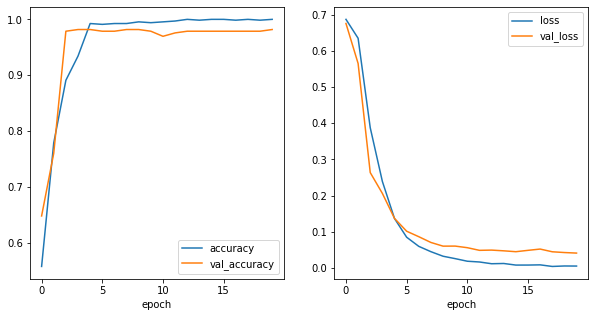

In [178]:
vocab_size = max([max(arr) for arr in word_to_vec(posts)])
embedding_size = 32
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_size, input_length=longest_post))
lstm_model.add(LSTM(embedding_size))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))
print(lstm_model.summary())

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

csv_logger = CSVLogger("lstm_model.csv", append=False)

fit_model(lstm_model, num_epochs,0,X_train, y_train,X_test,y_test)

print('Test accuracy:', model_acc(lstm_model,X_test, y_test))

acc_graphs(lstm_model)


### Word-wise CNN Model
https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 32, 50)            104000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 25, 50)            20050     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 12, 50)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 600)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                6010      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 11        
Total params: 130,071
Trainable params: 130,071
Non-trainable params: 0
_______________________________________________

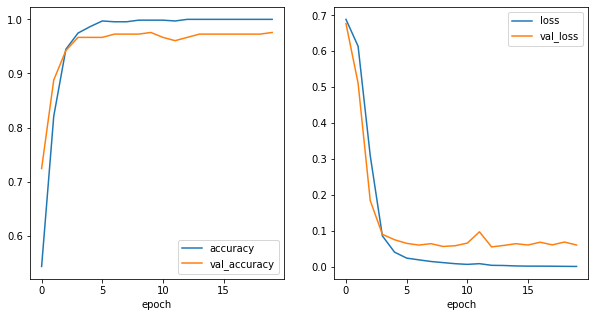

In [180]:
embedding_size = 50
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_size, input_length=longest_post))
cnn_model.add(Conv1D(embedding_size,kernel_size=8, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(cnn_model.summary())

fit_model(cnn_model, num_epochs,0,X_train, y_train,X_test,y_test)

print('Test accuracy:', model_acc(cnn_model,X_test, y_test))

acc_graphs(cnn_model)


##### Problems with this approach:
- after coding this section, I realized that using the entire set to build the embedding dictionary is "cheating": in the real world, we would not have access to the test data
- I decided to see how much the results would be affected by separating train and test data before building the dictionary
- unfortunately, the results were much worse. This makes sense because missing words would have no assocation to a label
- this is why we want to use similarity vectors for words.
- as you can see below, the in-sample accuracy converges to nearly 1, while the validation accuracy hovers around 50%
- below, you can see how my custom-dictionary model fails when the dictionary is built only with training data

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


X_train shape: (800, 149) (800,)
X_test shape: (200, 149) (200,)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 32, 32)            66560     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 74,913
Trainable params: 74,913
Non-trainable params: 0
_________________________________________________________________
None
7/7 [==============================] - 0s 11ms/step - loss: 2.4041 - accuracy: 0.3100
Test accuracy: 0.3100000023841858


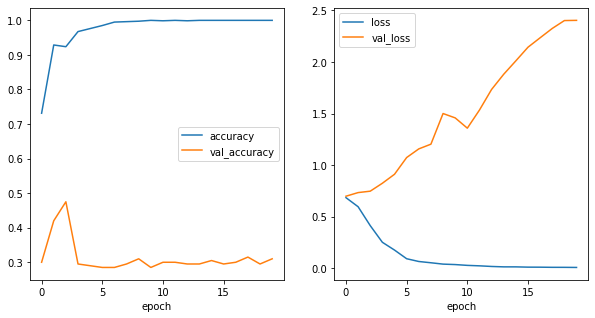

In [181]:
def preprocess(df):
    # separate into positive and negative posts
    positive_posts = pd.Series.to_numpy(df[df.label == 1]['text'])
    negative_posts = pd.Series.to_numpy(df[df.label == 0]['text'])

    # keep an object with both sets for later use
    posts = np.append(negative_posts, positive_posts, axis=0)
    
    neg_encoded = word_to_vec(negative_posts)
    pos_encoded = word_to_vec(positive_posts)
    word_vecs = np.concatenate((neg_encoded, pos_encoded))
    
    # Padding the data samples to a maximum review length in words
#     longest_post = max([len(post) for post in word_to_vec(posts)])
    padded_word_vecs = sequence.pad_sequences(word_vecs, maxlen=149)
    
    labels = np.concatenate((np.zeros(len(neg_encoded)), np.ones(len(pos_encoded))))
    
    return padded_word_vecs,labels

X_train, y_train = preprocess(train_df)
X_test, y_test = preprocess(test_df)

print('X_train shape:', X_train.shape, y_train.shape)
print('X_test shape:', X_test.shape, y_test.shape)

vocab_size = max([max(arr) for arr in word_to_vec(posts)])
embedding_size = 32
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_size, input_length=longest_post))
lstm_model.add(LSTM(embedding_size))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))
print(lstm_model.summary())

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

fit_model(lstm_model, num_epochs,0,X_train, y_train,X_test,y_test)

print('Test accuracy:', model_acc(lstm_model,X_test, y_test))

acc_graphs(lstm_model)


In [19]:
#todo: play around with different values for the two models above. 
# Add different layers
# show convergence of validation loss after number of epochs
# show difference using dictionaries from full set vs just train set

##### So, I am re-doing the character-wise model with GloVe pre-trained embeddings:

In [ ]:
# a class to split into test and train data

class wordVec:
    def __init__(self, data):
        self.samples = pd.Series.to_numpy(data.text)
        self.labels = pd.Series.to_numpy(data.label)
        
        self.train_samples = None
        self.val_samples = None
        
        self.train_labels = None
        self.val_labels = None

    def split(self, n):
        rng = np.random.RandomState(seed)
        rng.shuffle(self.samples)
        rng = np.random.RandomState(seed)
        rng.shuffle(self.labels)

        # Extract a training & validation split
        validation_split = n
        num_validation_samples = int(validation_split * len(self.samples))
        self.train_samples = self.samples[:-num_validation_samples]
        self.val_samples = self.samples[-num_validation_samples:]
        self.train_labels = self.labels[:-num_validation_samples]
        self.val_labels = self.labels[-num_validation_samples:]

In [46]:
# Split to train and test

yelp_labelled = pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
yelp_labelled.columns = ['text', 'label']

yelpVec = wordVec(yelp_labelled)
yelpVec.split(0.2)
yelpVec.train_samples[0]


'Overpriced for what you are getting.'

In [47]:
#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(yelpVec.train_samples))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(yelpVec.train_samples) #x_tr
x_val_seq = tokenizer.texts_to_sequences(yelpVec.val_samples) #x_val

#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=100)
x_val_seq = pad_sequences(x_val_seq, maxlen=100)

size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

1816


In [182]:
X_train = np.array(x_tr_seq),
y_train = np.array(yelpVec.train_labels)

X_test = np.array(x_val_seq),
y_test = np.array(yelpVec.val_labels)


In [183]:
def load_pretrained():
    path_to_glove_file = os.path.join(
        os.path.expanduser("~"), ".keras/datasets/glove.6B.300d.txt"
    )

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))
    return embeddings_index

In [184]:
embed_index = load_pretrained()

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embed_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


Found 400000 word vectors.


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 300)          544800    
_________________________________________________________________
lstm_11 (LSTM)               (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
_________________________________________________________________
flatten_11 (Flatten)         (None, 1)                 0         
Total params: 772,769
Trainable params: 227,969
Non-trainable params: 544,800
_________________________________________

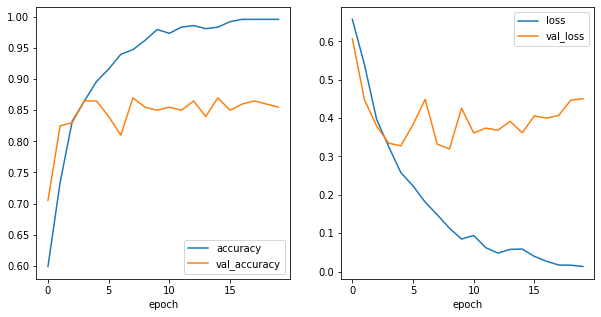

In [185]:
embedding_size = 50
lstm_glove_model = Sequential()
lstm_glove_model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False))
lstm_glove_model.add(LSTM(128,return_sequences=True,dropout=0.2))
lstm_glove_model.add(GlobalMaxPooling1D())
lstm_glove_model.add(Dense(64,activation='relu')) 
lstm_glove_model.add(Dense(1,activation='sigmoid')) 
lstm_glove_model.add(Flatten())
lstm_glove_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(lstm_glove_model.summary())

fit_model(lstm_glove_model, num_epochs,0,X_train, y_train,X_test,y_test)

print('Test accuracy:', model_acc(lstm_glove_model,X_test, y_test))

acc_graphs(lstm_glove_model)


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 300)          544800    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 93, 50)            120050    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 46, 50)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2300)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 10)                23010     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 11        
Total params: 687,871
Trainable params: 143,071
Non-trainable params: 544,800
_________________________________________

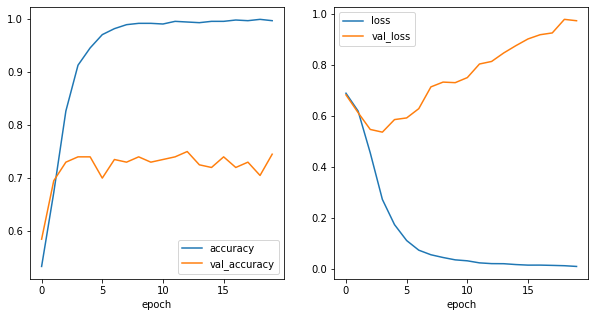

In [186]:
embedding_size = 50
cnn_glove_model = Sequential()
cnn_glove_model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False))
cnn_glove_model.add(Conv1D(embedding_size,kernel_size=8, activation='relu'))
cnn_glove_model.add(MaxPooling1D(pool_size=2))
cnn_glove_model.add(Flatten())
cnn_glove_model.add(Dense(10, activation='relu'))
cnn_glove_model.add(Dense(1, activation='sigmoid'))
cnn_glove_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(cnn_glove_model.summary())

fit_model(cnn_glove_model, num_epochs,0,X_train, y_train,X_test,y_test)

print('Test accuracy:', model_acc(cnn_glove_model,X_test, y_test))

acc_graphs(cnn_glove_model)


### Vectorize the character data

In [192]:
def char_tokenizer(lines):
    tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
    lines_low = [[l.lower() for l in lines]]
    tk.fit_on_texts(lines_low)

    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
    char_dict = {}
    for i, char in enumerate(alphabet):
        char_dict[char] = i + 1

    # Use char_dict to replace the tk.word_index
    tk.word_index = char_dict.copy()
    # Add 'UNK' to the vocabulary
    tk.word_index[tk.oov_token] = max(char_dict.values()) + 1
    return tk

In [193]:
def embed_weights(tk):
    vocab_size = len(tk.word_index)
    embedding_weights = []
    embedding_weights.append(np.zeros(vocab_size))

    for char,i in tk.word_index.items():
        onehot = np.zeros(vocab_size)
        onehot[i-1] = 1
        embedding_weights.append(onehot)

    return np.array(embedding_weights)

In [194]:
# transform reviews into character encodings:

posts = positive_posts + negative_posts
tk = char_tokenizer(posts)
vocab_size = len(tk.word_index)
pos_seqs = tk.texts_to_sequences(positive_posts)
neg_seqs = tk.texts_to_sequences(negative_posts)
print(f'{positive_posts[0]} becomes {pos_seqs[0]}')

And service was super friendly. becomes [1, 14, 4, 69, 19, 5, 18, 22, 9, 3, 5, 69, 23, 1, 19, 69, 19, 21, 16, 5, 18, 69, 6, 18, 9, 5, 14, 4, 12, 25, 39]


In [195]:
longest_post = max([len(x) for x in np.append(neg_seqs, pos_seqs, axis=0)])
print(f'longest post is {longest_post} characters long')

longest post is 149 characters long


In [196]:
# pad data:

pos_seq_padded = pad_sequences(pos_seqs, maxlen=longest_post, padding='post')
neg_seq_padded = pad_sequences(neg_seqs, maxlen=longest_post, padding='post')

pos_data = np.array(pos_seq_padded, dtype='float32')
neg_data = np.array(neg_seq_padded, dtype='float32')
pos_data[0]

array([ 1., 14.,  4., 69., 19.,  5., 18., 22.,  9.,  3.,  5., 69., 23.,
        1., 19., 69., 19., 21., 16.,  5., 18., 69.,  6., 18.,  9.,  5.,
       14.,  4., 12., 25., 39.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [198]:
padded_char_vecs = np.append(neg_data, pos_data, axis = 0)

labels = np.concatenate((np.zeros(len(neg_data)), np.ones(len(pos_data))))
X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(padded_char_vecs, labels, test_size=0.33)

print('X_train_char shape:', X_train_char.shape, y_train_char.shape)
print('X_test_char shape:', X_test_char.shape, y_test_char.shape)

X_train_char shape: (670, 149) (670,)
X_test_char shape: (330, 149) (330,)


In [36]:
# define embedding layer 
def embed_weights(tk):
    vocab_size = len(tk.word_index)
    embedding_weights = []
    embedding_weights.append(np.zeros(vocab_size))

    for char,i in tk.word_index.items():
        onehot = np.zeros(vocab_size)
        onehot[i-1] = 1
        embedding_weights.append(onehot)

    return np.array(embedding_weights)

In [26]:
embedding_size = 69 #TODO: find where this number comes from
input_size = longest_post
em_weights = embed_weights(tk)
embedding_layer = Embedding(vocab_size+1,embedding_size,input_length=input_size,weights=[em_weights])


### Tune and run the character-wise CNN model
https://realpython.com/python-keras-text-classification/

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 149, 69)           4830      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 142, 50)           27650     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 50)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 11        
Total params: 33,001
Trainable params: 33,001
Non-trainable params: 0
_________________________________________________

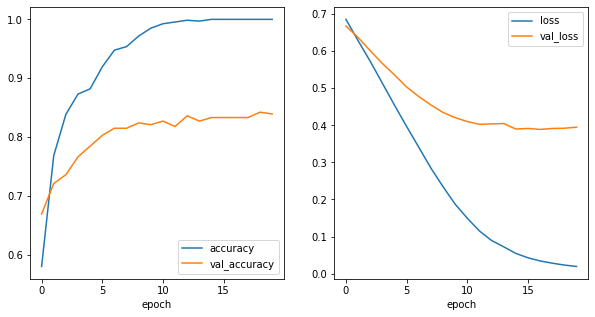

In [199]:
cnn_char_model = Sequential()
cnn_char_model.add(embedding_layer)
cnn_char_model.add(Conv1D(embedding_size, kernel_size=8, activation='relu'))
# cnn_char_model.add(MaxPooling1D(pool_size=2))
cnn_char_model.add(GlobalMaxPooling1D())

cnn_char_model.add(Flatten())
cnn_char_model.add(Dense(10, activation='relu'))
cnn_char_model.add(Dense(1, activation='sigmoid'))
cnn_char_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn_char_model.summary())

fit_model(cnn_char_model, num_epochs,0,
          X_train_char, y_train_char,
          X_test_char,y_test_char)

print('Test accuracy:', model_acc(cnn_char_model,X_test_char, y_test_char))

acc_graphs(cnn_char_model)
